<h3>Import Libraries</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

In [2]:
df= pd.read_csv('sales_data.csv')
forecast= pd.read_csv('test_data.csv')

In [3]:
test= df.tail(24)
df= df.head(84)

In [4]:
df.tail()

,Date,Units Sold
79,2006-08,4509
80,2006-09,13509
81,2006-10,17575
82,2006-11,25570
83,2006-12,35935


<h3>Checking for missing values</h3>

In [5]:
df.isnull().sum()

Date          0
Units Sold    0
dtype: int64

In [6]:
test.isnull().sum()

Date          0
Units Sold    0
dtype: int64

<h3>Parsing and setting date as index</h3>

In [7]:
df['Date']= pd.to_datetime(df['Date'], format = "%Y-%m")
df.set_index('Date',inplace=True)

In [8]:
df.head()

,Units Sold
Date,
2000-01-01,7185
2000-02-01,7248
2000-03-01,7393
2000-04-01,6835
2000-05-01,7872


In [9]:
test['Date']= pd.to_datetime(test['Date'], format = "%Y-%m")
test.set_index('Date',inplace=True)
forecast['Date']= pd.to_datetime(forecast['Date'], format = "%Y-%m")
forecast.set_index('Date',inplace=True)

<h3>Visualizing Data</h3>

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


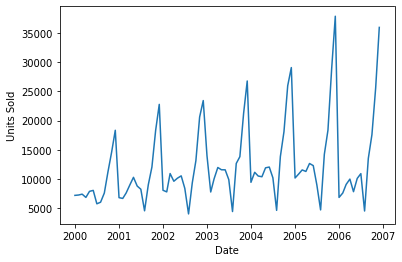

In [10]:
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.plot(df)

<h1>Making the time series stationary</h1>

<h3>Original Data</h3>

<h6>Visualizing Data</h6>

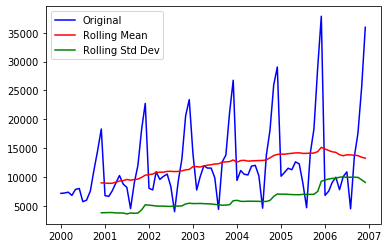

In [11]:
rolling_mean = df.rolling(window=12).mean()
rolling_stddev = df.rolling(window=12).std()
original = plt.plot(df, color='blue', label='Original')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
std = plt.plot(rolling_stddev, color='green', label='Rolling Std Dev')
plt.legend(loc='upper left')

<h6>Dickey–Fuller test</h6>

In [12]:
print('Dickey Fuller Test:')
dftest = adfuller(df['Units Sold'], autolag='AIC')

dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Dickey Fuller Test:
Test Statistic         -2.246453
p-value                 0.189820
Critical Value (1%)    -3.524624
Critical Value (5%)    -2.902607
Critical Value (10%)   -2.588679
dtype: float64


The p-value is is too high to reject the null hypothesis. We will try to emodel the data better 

<h3>Log Transform and differencing</h3>

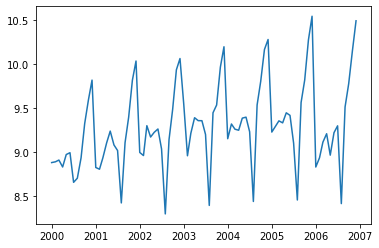

In [13]:
df_log= np.log(df)
plt.plot(df_log)

In [14]:
df_log_time_shift = df_log - df_log.shift(12)
df_log_time_shift.dropna(inplace=True)
df_log_time_shift.head()

,Units Sold
Date,
2001-01-01,-0.055808
2001-02-01,-0.084156
2001-03-01,0.025903
2001-04-01,0.272721
2001-05-01,0.266110


<h6>Visualizing Data</h6>

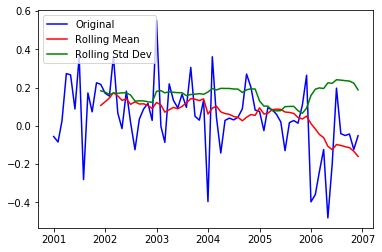

In [15]:
rolling_mean = df_log_time_shift.rolling(window=12).mean()
rolling_stddev = df_log_time_shift.rolling(window=12).std()
original = plt.plot(df_log_time_shift, color='blue', label='Original')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
std = plt.plot(rolling_stddev, color='green', label='Rolling Std Dev')
plt.legend(loc='upper left')

<h6>Dickey–Fuller test</h6>

In [16]:
print('Dickey Fuller Test:')
dftest = adfuller(df_log_time_shift['Units Sold'], autolag='AIC')

dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Dickey Fuller Test:
Test Statistic         -3.166241
p-value                 0.022024
Critical Value (1%)    -3.528890
Critical Value (5%)    -2.904440
Critical Value (10%)   -2.589656
dtype: float64


The p-value is low enough to reject the null hypothesis. But we will attempt to model the data better

<h3>Time shifting Algorithm</h3>

In [17]:
df_time_shift= df- df.shift(12)

<h6>Visualizing Data</h6>

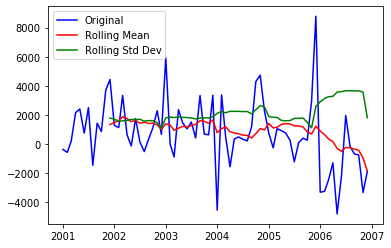

In [18]:
rolling_mean = df_time_shift.rolling(window=12).mean()
rolling_stddev = df_time_shift.rolling(window=12).std()
original = plt.plot(df_time_shift, color='blue', label='Original')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
std = plt.plot(rolling_stddev, color='green', label='Rolling Std Dev')
plt.legend(loc='upper left')

<h6>Dickey–Fuller test</h6>

In [19]:
print('Dickey Fuller Test:')
dftest = adfuller(df_time_shift['Units Sold'].dropna(), autolag='AIC')

dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Dickey Fuller Test:
Test Statistic         -6.798172e+00
p-value                 2.272638e-09
Critical Value (1%)    -3.526005e+00
Critical Value (5%)    -2.903200e+00
Critical Value (10%)   -2.588995e+00
dtype: float64


The p-value is considerable low to reject the null hypothesis. Our remodeled data tests positive for being stationary

<h1> ACF & PACF plots </h1>

<Figure size 864x576 with 0 Axes>

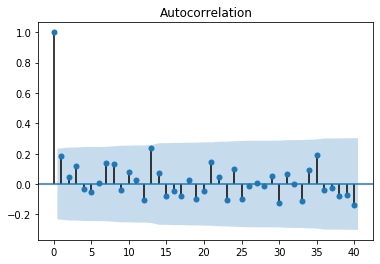

<Figure size 864x576 with 0 Axes>

In [20]:
sm.graphics.tsa.plot_acf(df_time_shift.iloc[13:],lags=40)
plt.figure(figsize=(12,8))

<Figure size 864x576 with 0 Axes>

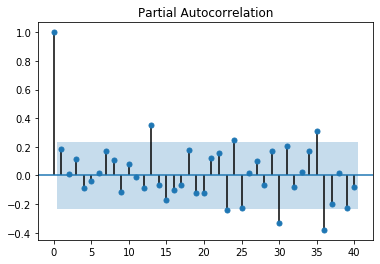

<Figure size 864x576 with 0 Axes>

In [21]:
sm.graphics.tsa.plot_pacf(df_time_shift.iloc[13:],lags=40)
plt.figure(figsize=(12,8))

After examining the Partial Autocorrelation and Autocorrelation graph we will set the p value to 1 and q value to 1. As we perform the time differencing once we will set the d value to 1

<h1>Predict</h1>

In [22]:
model= sm.tsa.statespace.SARIMAX(df['Units Sold'], order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit() 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


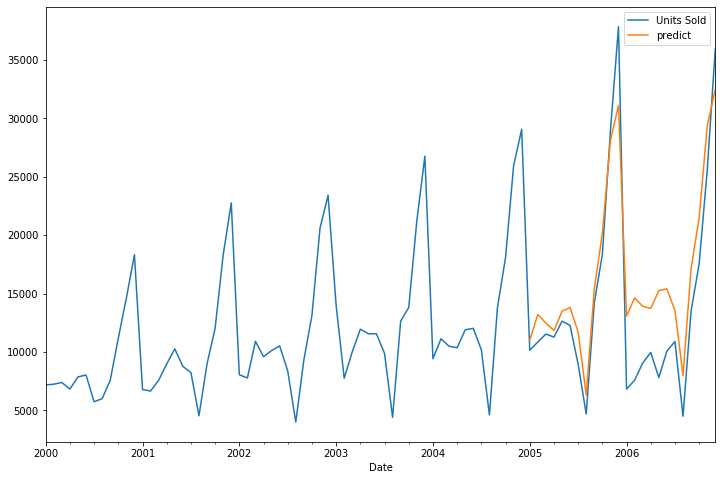

In [23]:
df['predict']=results.predict(start=60,end=84,dynamic=True)
df[['Units Sold','predict']].plot(figsize=(12,8))

In [24]:
df= pd.concat([df,test], sort=True)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


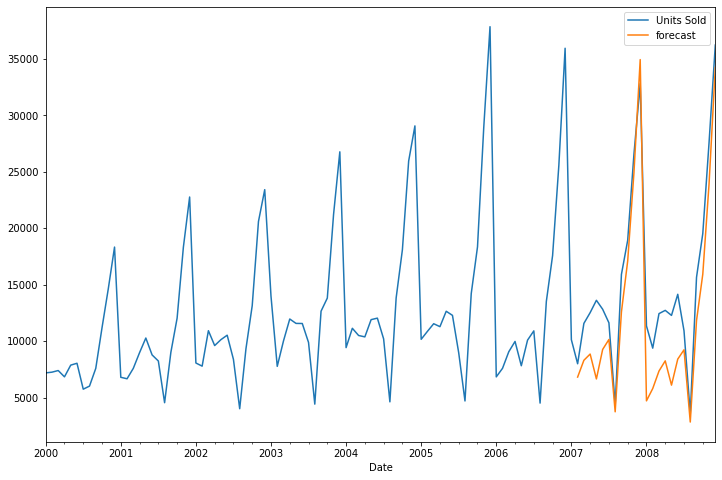

In [25]:
df['forecast'] = results.predict(start = 85, end = 108, dynamic= True)  
df[['Units Sold', 'forecast']].plot(figsize=(12, 8))

In [26]:
df= pd.concat([df,test, forecast], sort=True)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


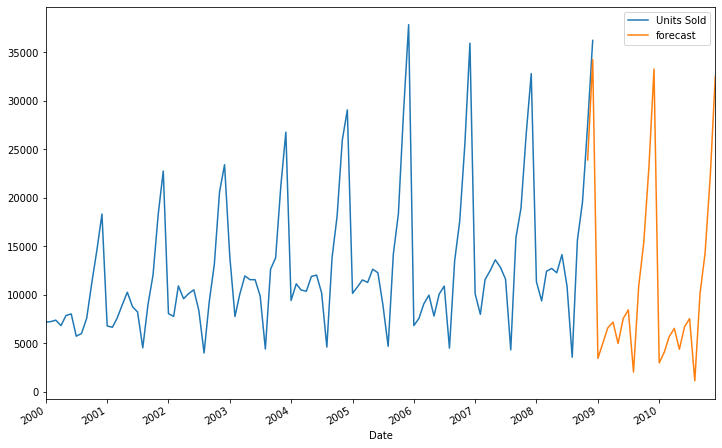

In [27]:
df['forecast'] = results.predict(start = 106, end = 132, dynamic= True)  
df[['Units Sold', 'forecast']].plot(figsize=(12, 8))